# Doing inference with SageMaker Built-in Object Detection model

1. [Download the trained model artifact](#download)
1. [Convert training model to deployable model](#convert)
1. [Inference](#inference)
  1. [model load](#load)
  1. [single image inference](#singleinference)
  1. [batch inference](#batchinference)


## setup

In [1]:
%matplotlib inline

In [2]:
!pip install opencv-python
!pip install gluoncv

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import download, viz
import numpy as np
import mxnet as mx
import json
import boto3
import cv2

# Download the trained model artifact <a id='download'></a>

The trained model parameters along with its network definition is stored in a tar.gz file in the output path for the training job. We need to download and unzip it to local disk:

In [4]:
JOB_ID='<please replace with your training job name>' 
S3_OUTPUT_BUCKET = '<please replace with your s3 bucket name>'

In [5]:
JOB_ID='od-demo-2019-08-01-04-57-12'  
S3_OUTPUT_BUCKET = 'angelaw-test-sagemaker-blog'

In [6]:
sagemaker_client =  boto3.client('sagemaker')
MODEL_ARTIFACT = sagemaker_client.describe_training_job(TrainingJobName=JOB_ID)['ModelArtifacts']['S3ModelArtifacts']
MODEL_ARTIFACT

u's3://angelaw-test-sagemaker-blog/demo/output/od-demo-2019-08-01-04-57-12/output/model.tar.gz'

In [7]:
import os 

def make_tmp_folder(folder_name):
    try:
        os.makedirs(folder_name)
    except OSError as e:
        print("{} folder already exists".format(folder_name))

In [8]:
TMP_FOLDER = 'trained-model'
make_tmp_folder(TMP_FOLDER)

!aws s3 cp $MODEL_ARTIFACT $TMP_FOLDER/.

trained-model folder already exists
download: s3://angelaw-test-sagemaker-blog/demo/output/od-demo-2019-08-01-04-57-12/output/model.tar.gz to trained-model/model.tar.gz


Unzipping the model you will find three files in your directory:
```
model_algo_1-symbol.json   <-- neural network definition 
hyperparams.json           <-- hyper parameters  
model_algo_1-0000.params   <-- trained weights for the neural network
```

In [9]:
!tar -xvzf $TMP_FOLDER/model.tar.gz -C $TMP_FOLDER/

hyperparams.json
model_algo_1-symbol.json
model_algo_1-0000.params


# Convert the training model to a deployable model <a id='convert'></a>

The model output produced by the built-in object detection model leaves the loss layer in place and does not include a [non-max suppression (NMS) layer](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH). To make it ready for inference on our machine, we need to remove the loss layer and add the NMS layer. We will be using a script from this GitHub repo: https://github.com/zhreshold/mxnet-ssd

Make sure to clone this Git repo to your ~/SageMaker folder

```
cd ~/SageMaker
git clone https://github.com/zhreshold/mxnet-ssd.git
```

In [10]:
%%sh
cd ~/SageMaker
git clone https://github.com/zhreshold/mxnet-ssd.git

fatal: destination path 'mxnet-ssd' already exists and is not an empty directory.


You need to run the `deploy.py` script to convert a trained model to a deployable model. I  found that you must use python2 to run this script successfully.

In [11]:
!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py -h

Using mxnet as:
<module 'mxnet' from '/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/__init__.pyc'>
(export MXNET_EXAMPLE_SSD_DISABLE_PRE_INSTALLED=1) to prevent loading pre-installed mxnet.
usage: deploy.py [-h] [--network NETWORK] [--epoch EPOCH] [--prefix PREFIX]
                 [--data-shape DATA_SHAPE] [--num-class NUM_CLASSES]
                 [--nms NMS_THRESH] [--force FORCE_NMS] [--topk NMS_TOPK]

Convert a trained model to deploy model

optional arguments:
  -h, --help            show this help message and exit
  --network NETWORK     which network to use
  --epoch EPOCH         epoch of trained model
  --prefix PREFIX       trained model prefix
  --data-shape DATA_SHAPE
                        data shape
  --num-class NUM_CLASSES
                        number of classes
  --nms NMS_THRESH      non-maximum suppression threshold, default 0.5
  --force FORCE_NMS     force non-maximum suppression on different class
  --topk NMS_TOPK       apply nms o

When running this script, you need to make sure that command line options you pass in match exactly the hyperparameters of your training job. If you’re unsure, refer the hyperparams.json file in your unpacked model artifacts to confirm. 

In [12]:
!cat $TMP_FOLDER/hyperparams.json

{"label_width": "150", "early_stopping_min_epochs": "10", "epochs": "30", "overlap_threshold": "0.5", "lr_scheduler_factor": "0.25", "_num_kv_servers": "auto", "weight_decay": "0.0005", "mini_batch_size": "30", "use_pretrained_model": "1", "freeze_layer_pattern": "", "lr_scheduler_step": "10,20", "early_stopping": "False", "early_stopping_patience": "5", "momentum": "0.9", "num_training_samples": "5870", "optimizer": "sgd", "_tuning_objective_metric": "", "early_stopping_tolerance": "0.0", "learning_rate": "0.001", "kv_store": "device", "nms_threshold": "0.45", "num_classes": "2", "base_network": "resnet-50", "nms_topk": "400", "_kvstore": "device", "image_shape": "512"}

In [13]:
!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py --network resnet50 --num-class 2 --nms .45 --data-shape 512 --prefix $TMP_FOLDER/model_algo_1

Using mxnet as:
<module 'mxnet' from '/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/__init__.pyc'>
(export MXNET_EXAMPLE_SSD_DISABLE_PRE_INSTALLED=1) to prevent loading pre-installed mxnet.
Saved model: trained-model/deploy_model_algo_1-0000.params
Saved symbol: trained-model/deploy_model_algo_1-symbol.json


In [14]:
!ls -alh $TMP_FOLDER

total 308M
drwxrwxr-x 2 ec2-user ec2-user 4.0K Aug  1 18:48 .
drwxrwxr-x 7 ec2-user ec2-user 4.0K Aug  1 18:48 ..
-rw-rw-r-- 1 ec2-user ec2-user 106M Aug  1 18:48 deploy_model_algo_1-0000.params
-rw-rw-r-- 1 ec2-user ec2-user 129K Aug  1 18:48 deploy_model_algo_1-symbol.json
-rw-r--r-- 1 ec2-user ec2-user  679 Aug  1 05:35 hyperparams.json
-rw-r--r-- 1 ec2-user ec2-user 106M Aug  1 05:35 model_algo_1-0000.params
-rw-r--r-- 1 ec2-user ec2-user 130K Aug  1 05:35 model_algo_1-symbol.json
-rw-rw-r-- 1 ec2-user ec2-user  98M Aug  1 05:36 model.tar.gz


Save the copy of the deployable model artifact in S3

In [15]:
!aws s3 cp $TMP_FOLDER/deploy_model_algo_1-0000.params s3://$S3_OUTPUT_BUCKET/deployable-model/
!aws s3 cp $TMP_FOLDER/deploy_model_algo_1-symbol.json s3://$S3_OUTPUT_BUCKET/deployable-model/

upload: trained-model/deploy_model_algo_1-0000.params to s3://angelaw-test-sagemaker-blog/deployable-model/deploy_model_algo_1-0000.params
upload: trained-model/deploy_model_algo_1-symbol.json to s3://angelaw-test-sagemaker-blog/deployable-model/deploy_model_algo_1-symbol.json


# 3. Doing inference with the model on local host <a id='inference'></a>

Below code will run inference on a set of test images on the current notebook instance. Using a GPU instance (e.g. p2.\*, p3.\* family) will result in faster performance than CPU only instances. You can stop the SageMaker notebook instance and update the instance type, and restart the notebook instance before continuing. 

In [16]:
def get_ctx():
    try:
        gpus = mx.test_utils.list_gpus()
        if len(gpus) > 0:
            ctx = []
            for gpu in gpus:
                ctx.append(mx.gpu(gpu))
        else:
            ctx = [mx.cpu()]
    except:
        ctx = [mx.cpu()]
    return ctx

ctx = get_ctx()[0]
ctx

gpu(0)

In [17]:
SHAPE = 512
input_shapes=[('data', (1, 3, SHAPE, SHAPE))]
confidence_threshold = 0.3
CLASSES = ['blue box', 'yellow box']


## 3A. Loading the model <a id="load"> </a>

In [18]:
%%time

param_path=os.path.join(TMP_FOLDER, 'deploy_model_algo_1')
print("param_path: {}".format(param_path))
sym, arg_params, aux_params = mx.model.load_checkpoint(param_path, 0)
mod = mx.mod.Module(symbol=sym, label_names=[], context=ctx)
mod.bind(for_training=False, data_shapes=input_shapes)
mod.set_params(arg_params, aux_params)

param_path: trained-model/deploy_model_algo_1
CPU times: user 2.26 s, sys: 1.21 s, total: 3.47 s
Wall time: 3.31 s


In [19]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def predict_from_file(filepath, reshape=(SHAPE, SHAPE)):
    # Switch RGB to BGR format (which ImageNet networks take)
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    if img is None:
        return []

     # Resize image to fit network input
    img = cv2.resize(img, reshape)
    
    org_image = img.copy()
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
 
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    return prob, org_image

In [20]:
def infer(image_path, threshold=confidence_threshold):
    results, org_image = predict_from_file(image_path)
    image_name = image_path.split("/")[-1]
    
    filtered_result = results[results[:, 0] != -1]
    filtered_result = filtered_result[filtered_result[:, 1] >=threshold]
    
    return filtered_result, org_image

## 3B. Test inference on single image <a id="singleinference"></a>

In [21]:
!aws s3 cp s3://greengrass-object-detection-blog/frames/validation_box_video/validation_box_video_000298.jpg .

download: s3://greengrass-object-detection-blog/frames/validation_box_video/validation_box_video_000298.jpg to ./validation_box_video_000298.jpg


In [22]:
%%time

prediction_image = 'validation_box_video_000298.jpg'
results, org_image = infer(prediction_image)

CPU times: user 363 ms, sys: 1.42 s, total: 1.78 s
Wall time: 4.73 s


In [23]:
results[:, (2, 4)] *= SHAPE
results[:, (3, 5)] *= SHAPE

In [24]:
org_image.shape

(512, 512, 3)

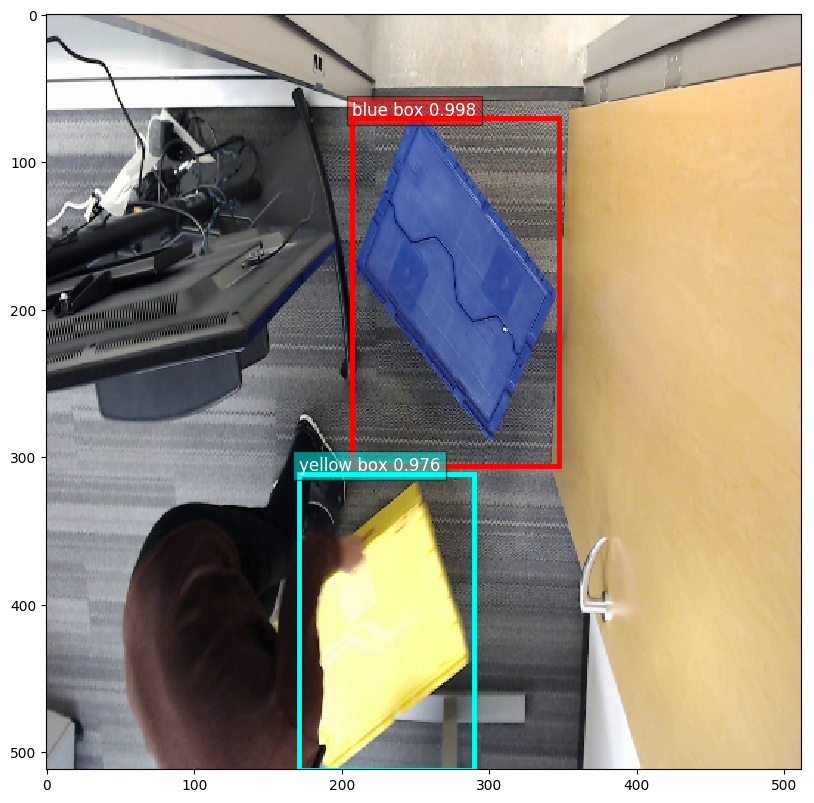

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), facecolor='white', dpi=100)
axis=axes

ax = viz.plot_bbox(org_image, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)

## 3C. Run inference on a batch of test images (~2 minutes on a p3.2xlarge instance, longer on cpu instances for 469 images) <a id="singleinference"></a>

In [26]:
VALIDATION_IMAGE_FOLDER = 'validation'
make_tmp_folder(VALIDATION_IMAGE_FOLDER)

validation folder already exists


In [27]:
!aws s3 sync s3://greengrass-object-detection-blog/frames/validation_box_video/ $VALIDATION_IMAGE_FOLDER/ --quiet

In [28]:
!ls -1 $VALIDATION_IMAGE_FOLDER/ | wc -l

469


In [29]:
%%time 

img_list = os.listdir(VALIDATION_IMAGE_FOLDER)

output_file = 'validation-inference-results.json'
with open(output_file, "w") as outfile:
    for img in img_list:
        if img.endswith("jpg"):
            result,_orig = infer(os.path.join(VALIDATION_IMAGE_FOLDER, img))
            to_write = {"image": img, "prediction": result.tolist()}
            outfile.write(json.dumps(to_write))
            outfile.write('\n')

CPU times: user 28.2 s, sys: 7.11 s, total: 35.3 s
Wall time: 16 s


In [30]:
!head $output_file


{"image": "validation_box_video_000348.jpg", "prediction": [[0.0, 0.9980637431144714, 0.25763291120529175, 0.5775729417800903, 0.5947221517562866, 0.9647700786590576]]}
{"image": "validation_box_video_000204.jpg", "prediction": [[1.0, 0.9971373081207275, 0.41788768768310547, 0.5311288833618164, 0.6566970348358154, 0.8487093448638916]]}
{"image": "validation_box_video_000450.jpg", "prediction": []}
{"image": "validation_box_video_000028.jpg", "prediction": [[1.0, 0.9965003728866577, 0.022731930017471313, 0.714321494102478, 0.33422210812568665, 0.9989490509033203]]}
{"image": "validation_box_video_000085.jpg", "prediction": [[1.0, 0.9680504202842712, 0.3369626998901367, 0.37517955899238586, 0.6720163822174072, 1.0]]}
{"image": "validation_box_video_000156.jpg", "prediction": [[1.0, 0.9856561422348022, 0.1945585310459137, 0.4274713099002838, 0.5452260971069336, 0.9821163415908813]]}
{"image": "validation_box_video_000041.jpg", "prediction": [[1.0, 0.9805145859718323, 0.1915075182914734, 0

In [31]:
visualization_pdf_name = 'validation-visualization.pdf'

In [37]:
%%time 

%run ./07_visualize_prediction_labels_batch.py -i $VALIDATION_IMAGE_FOLDER -l $output_file -f $visualization_pdf_name -c $confidence_threshold

INFO:__main__:doing inference for images in directory: validation
INFO:__main__:confidence filter: 0.3
INFO:__main__:output file name: validation-visualization.pdf
INFO:__main__:label file name: validation-inference-results.json. number of labels: 469
INFO:__main__:page number: 0, row number: 5, beginning index: 0, last index: 15
INFO:__main__:page number: 1, row number: 5, beginning index: 15, last index: 30
INFO:__main__:page number: 2, row number: 5, beginning index: 30, last index: 45
INFO:__main__:page number: 3, row number: 5, beginning index: 45, last index: 60
INFO:__main__:page number: 4, row number: 5, beginning index: 60, last index: 75
INFO:__main__:page number: 5, row number: 5, beginning index: 75, last index: 90
INFO:__main__:page number: 6, row number: 5, beginning index: 90, last index: 105
INFO:__main__:page number: 7, row number: 5, beginning index: 105, last index: 120
INFO:__main__:page number: 8, row number: 5, beginning index: 120, last index: 135
INFO:__main__:p

CPU times: user 1min 34s, sys: 869 ms, total: 1min 35s
Wall time: 1min 32s


<Figure size 432x288 with 0 Axes>

In [34]:
!aws s3 cp $visualization_pdf_name s3://$S3_OUTPUT_BUCKET/prediction-visualization/$JOB_ID/

upload: ./validation-visualization.pdf to s3://angelaw-test-sagemaker-blog/prediction-visualization/od-demo-2019-08-01-04-57-12/validation-visualization.pdf


You can open the [validation visualization pdf](./validation-visualization.pdf) on the notebook instance, or download the visualization PDF to your laptop to examine the prediction visualizaiton. e.g. 
```
aws s3 cp s3://greengrass-object-detection-blog/prediction-visualization/od-demo-2019-08-01-04-57-12/validation-visualization.pdf .
```